In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import requests
import matplotlib.pyplot as plt
import io
from PIL import Image
from nltk import tokenize


In [3]:
df = pd.read_csv("audioBooks.csv", delimiter=';')
df.head()

,img,title,author,genre,desc,readers,read-time
0,https://s13.knigavuhe.org/2/covers/41777/1-1.j...,Солнечные зайчики,Наталья Маркелова,"для детей, аудиосказки","Замечательная, очень светлая и тёплая книга дл...",Маленький Фонарщик,32 минуты
1,https://s9.knigavuhe.org/1/covers/41775/1-1.jpg?1,Шарлотта Аполлоновна,Лев Зиндер,"для детей, аудиосказки",За приключениями не обязательно отправляться в...,Анна Снегирева,3 часа 16 минут
2,https://s12.knigavuhe.org/2/covers/41774/1-1.j...,Сказка о ретивом начальнике,Михаил Салтыков-Щедрин,классика,"«В некотором царстве, в некотором государстве ...",Владимир Антоник,19 минут
3,https://s9.knigavuhe.org/2/covers/41773/1-1.jpg?1,Дом для бродяг,Олег Куваев,"роман, проза",Есть такое поверье: для каждого человека на зе...,Саша Жукова,2 часа 2 минуты
4,https://s9.knigavuhe.org/2/covers/41771/1-1.jpg?1,Приключение в воздушном океане,Джек Лондон,приключения,"Человек, летавший на аэростатах, вспоминает о ...",Артём Мещеряков,17 минут


<AxesSubplot: >

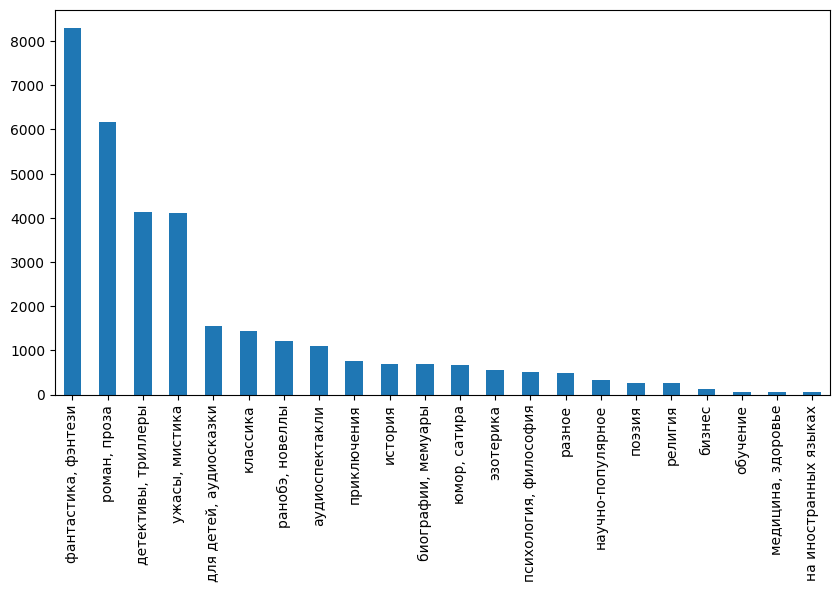

In [29]:
df['genre'].value_counts().plot(x = 'genre', y ='count', kind = 'bar', figsize = (10,5)  )

In [32]:
stops = ['в', 'без', 'до', 'для', 'за', 'через', 'над', 'по', 'из', 'у', 'около', 'под', 'о', 'про', 'на', 'к', 'перед', 'при', 'с', 'между',
             'я', 'ты', 'мы', 'вы', 'он', 'она', 'оно', 'они', 'себя', 'мой', 'твой', 'наш', 'ваш', 'свой', 'этот', 'тот', 'его' , 'её' , 'их',
             'кто', 'что',  'а', 'и', 'но', 'да', 'или', 'либо', 'тоже', 'также', 'зато', 'если', 'хотя', 'пока',
             'чтобы', 'как', 'будто', 'словно', 'точно'
        ]
    

In [7]:
def toLower(text):
    """Перевод строки в нижний регистр

    Args:
        text (string): исходная строка

    Returns:
        string: строка text в нижнем регистре
    """
    return str(text).lower()
    
def remove_punctuation(text):
    """Удаление пунктуационных знаков из строки

    Args:
        text (string): исходная строка

    Returns:
        string: строка text без пунктуации
    """
    tokenizer = tokenize.RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text    

def remove_stop_words(text):
    """Удаление стоп-слов из строки

    Args:
        text (string): исходная строка

    Returns:
        string: строка text без стоп-слов
    """
    
    text = [w for w in text.split() if not w in stops]
    
    text = " ".join(text)

    return text

In [8]:
df['cleaned_desc'] = df['desc'].apply(toLower)
df['cleaned_desc'] = df.cleaned_desc.apply(func=remove_punctuation)
df['cleaned_desc'] = df.cleaned_desc.apply(func=remove_stop_words)

In [16]:
def recommend_based_on_title(title, genre):
    """рекомендация на основе названия и жанра аудиокниги

    Args:
        title (string): название аудиокниги
        genre (string): жанр аудиокниги
    """
    data = df.loc[df['genre'] == genre]  
    
    #сборс индексов. Изначально индексы вырваны из общей массы
    data.reset_index(level = 0, inplace = True) 
    
    #серия - название, иднекс
    indices = pd.Series(data.index, index = data['title'])
    
    tf = TfidfVectorizer(analyzer='word', ngram_range=(2, 2), min_df = 1, stop_words=stops)
    tfidf_matrix = tf.fit_transform(data['title'])
    display(tfidf_matrix)
    
    #===============================================
    # Доразобрать ниже 
    
    sg = cosine_similarity(tfidf_matrix, tfidf_matrix)
    
    display(indices)
    idx = indices[title]# Get the pairwsie similarity scores 
    
    
    sig = list(enumerate(sg[idx]))# Sort the books
    sig = sorted(sig, key=lambda x: x[1], reverse=True)# Scores of the 5 most similar books 
    sig = sig[1:6]# Book indicies
    movie_indices = [i[0] for i in sig]
    
    rec = data[['title', 'img', 'desc']].iloc[movie_indices]
    
    display(rec)
       
    
    for i in rec['img']:
        response = requests.get(i)
        img = Image.open(io.BytesIO(response.content))
        plt.figure()
        print(plt.imshow(img))

<8298x8591 sparse matrix of type '<class 'numpy.float64'>'
	with 10321 stored elements in Compressed Sparse Row format>

title
Звёзды                                       0
Тау - Ноль                                   1
Похмелье                                     2
Заказ                                        3
Бета-тест                                    4
                                          ... 
Легион Безголовый                         8293
Сага о Тимофееве                          8294
Девушка, золотые часы… и всё остальное    8295
Истребитель Родина                        8296
Прорыв. Штормовое предупреждение          8297
Length: 8298, dtype: int64

,title,img,desc
347,"Человек, который видел завтра",https://s13.knigavuhe.org/2/covers/40210/1-1.j...,"Предсказатель судеб может уйти из жизни, тольк..."
2349,"Человек, который любил Файоли",https://s4.knigavuhe.org/2/covers/31381/1-1.jpg?1,"Фейоли видят только живых, а мёртвых – нет, и ..."
2508,"Человек, который убил Магомета",https://s4.knigavuhe.org/1/covers/30746/1-1.jpg?1,"Один безумный профессор, придя домой, застал с..."
2625,"Человек, который научился любить",https://s4.knigavuhe.org/2/covers/30289/1-1.jpg?1,"Человек, делающий открытие способное изменить ..."
3450,"Человек, который продал Луну",https://s4.knigavuhe.org/1/covers/26734/1-1.jpg?2,"Харриман был финансовым гением, щедро сыпавший..."


AxesImage(size=(220, 154))
AxesImage(size=(220, 154))
AxesImage(size=(220, 154))
AxesImage(size=(220, 154))
AxesImage(size=(220, 154))


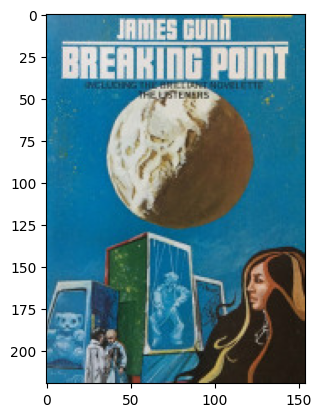

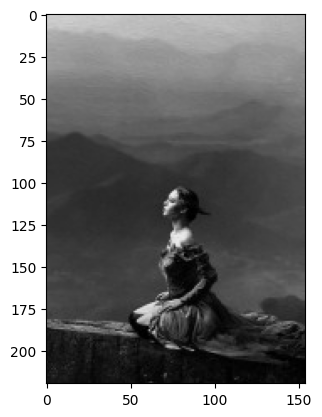

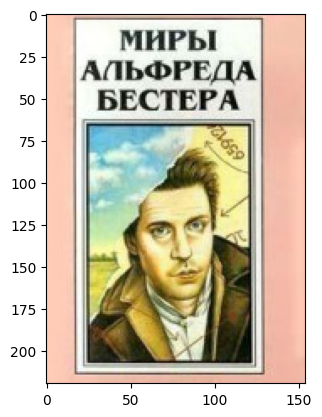

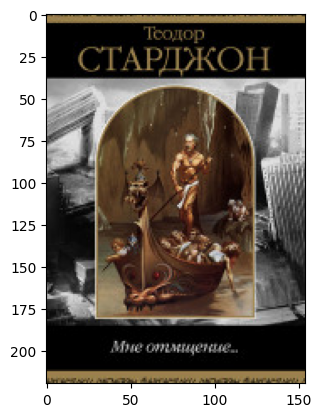

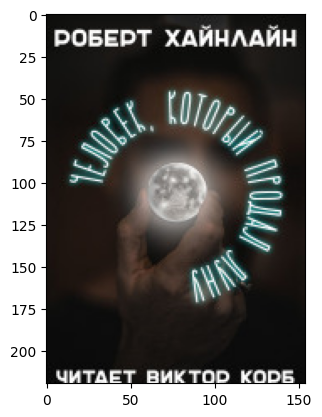

In [22]:
recommend_based_on_title('Человек, который помнил всё', 'фантастика, фэнтези')